In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import math
import random

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import keras
from keras import Model
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Input, InputLayer, Add, Concatenate
from keras.utils.vis_utils import plot_model

In [2]:
#plot history
def plot_history(history, *, n_epochs=None, plot_lr=False, title=None, bottom=None, top=None):
    """Plot (the last n_epochs epochs of) the training history
    
    Plots loss and optionally val_loss and lr."""
    plt.figure(figsize=(15, 6))
    from_epoch = 0 if n_epochs is None else max(len(history['loss']) - n_epochs, 0)
    
    # Plot training and validation losses
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['loss'][from_epoch:], label='Training loss')
    try:
        plt.plot(np.arange(from_epoch, len(history['loss'])), history['val_loss'][from_epoch:], label='Validation loss')
        best_epoch = np.argmin(np.array(history['val_loss']))
        best_val_loss = history['val_loss'][best_epoch]
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history['val_loss'])[:best_epoch])
            almost_val_loss = history['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')
    except KeyError:
        pass
    if bottom is not None: plt.ylim(bottom=bottom)
    if top is not None: plt.ylim(top=top)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    if title is not None: plt.title(title)
        
    # Plot learning rate
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(from_epoch, len(history['lr'])), np.array(history['lr'][from_epoch:]), color='g', label='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')
        
    display(plt.show())

In [3]:
#Data Locations
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

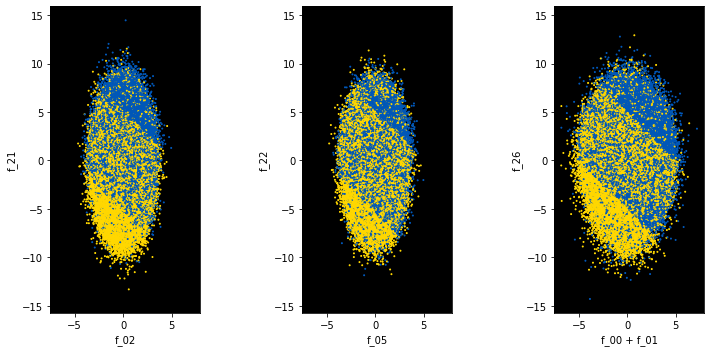

In [4]:
#features
plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])

ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue

In [5]:
#feature engineering
features = [f for f in test.columns if f != 'id' and f != 'f_27']
float_features = [f for f in features if test[f].dtype == float]
for df in [train, test]:
    # Extract the 10 letters of f_27 into individual features
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        
    # unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    
    # Feature interactions: create three ternary features
    # Every ternary feature can have the values -1, 0 and +1
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
features = [f for f in test.columns if f != 'id' and f != 'f_27']
float_features = [f for f in features if test[f].dtype == float]
int_features = [f for f in features if test[f].dtype == int and f.startswith('f')]
ch_features = [f for f in features if f.startswith('ch')]
test[features].head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,1,0,3,11,0,2,5,0,0,1
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,1,0,4,6,2,1,6,0,0,0


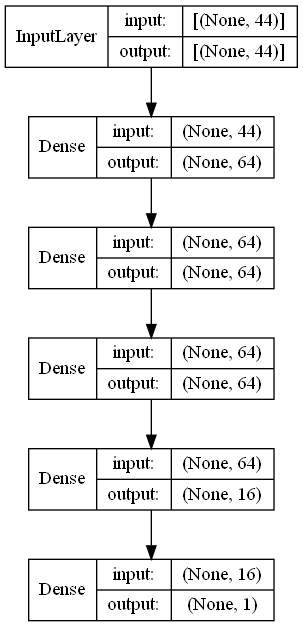

In [6]:
#model
def my_model():
    """Simple sequential neural network with four hidden layers.
    
    Returns a (not yet compiled) instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'
    inputs = Input(shape=(len(features)))
    x = Dense(64, kernel_regularizer=keras.regularizers.l2(40e-6),
              activation=activation,
             )(inputs)
    x = Dense(64, kernel_regularizer=keras.regularizers.l2(40e-6),
              activation=activation,
             )(x)
    x = Dense(64, kernel_regularizer=keras.regularizers.l2(40e-6),
              activation=activation,
             )(x)
    x = Dense(16, kernel_regularizer=keras.regularizers.l2(40e-6),
              activation=activation,
             )(x)
    x = Dense(1, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              activation='sigmoid',
             )(x)
    model = Model(inputs, x)
    return model

plot_model(my_model(), show_layer_names=False, show_shapes=True)

44 features
Fold 0.0 | 05:57 | Training loss: 0.0594 | Val loss: 0.0662 | AUC: 0.99805


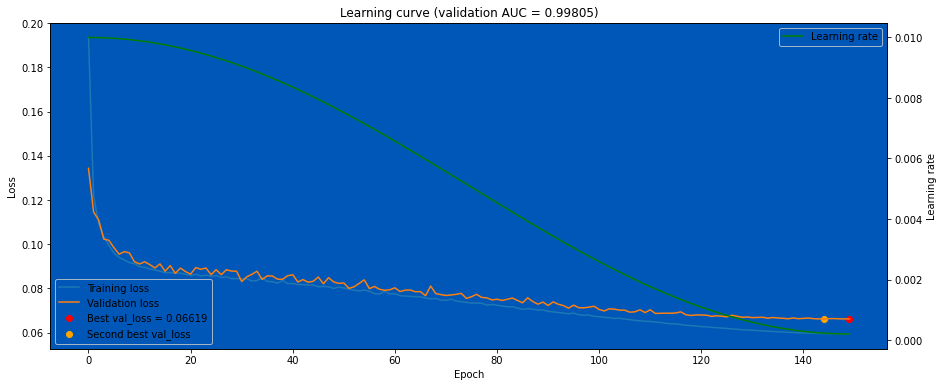

None

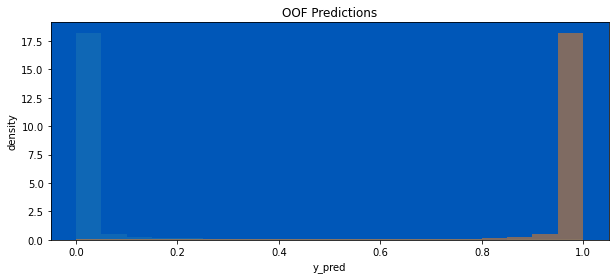

Fold 0.1 | 06:15 | Training loss: 0.0596 | Val loss: 0.0666 | AUC: 0.99804
Fold 0.2 | 06:02 | Training loss: 0.0591 | Val loss: 0.0669 | AUC: 0.99802
Fold 0.3 | 05:29 | Training loss: 0.0601 | Val loss: 0.0671 | AUC: 0.99798
Fold 0.4 | 05:22 | Training loss: 0.0595 | Val loss: 0.0666 | AUC: 0.99803
OOF AUC:                       0.99802


In [7]:
#Cross-validation

# Cross-validation of the classifier

EPOCHS = 200
EPOCHS_COSINEDECAY = 150
CYCLES = 1
VERBOSE = 0 # set to 0 for less output, or to 2 for more output
DIAGRAMS = True
USE_PLATEAU = False
BATCH_SIZE = 2048
ONLY_FIRST_FOLD = False

# see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

def fit_model(X_tr, y_tr, X_va=None, y_va=None, run=0):
    """Scale the data, fit a model, plot the training history and optionally validate the model
    
    Returns a trained instance of tensorflow.keras.models.Model.
    
    As a side effect, updates y_va_pred, history_list and score_list.
    """
    global y_va_pred
    start_time = datetime.datetime.now()
    
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    
    if X_va is not None:
        X_va = scaler.transform(X_va)
        validation_data = (X_va, y_va)
    else:
        validation_data = None

    # Define the learning rate schedule and EarlyStopping
    lr_start=0.01
    if USE_PLATEAU and X_va is not None: # use early stopping
        epochs = EPOCHS
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, 
                               patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                           patience=12, 
                           verbose=1,
                           mode="min", 
                           restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    else: # use cosine learning rate decay rather than early stopping
        epochs = EPOCHS_COSINEDECAY
        lr_end = 0.0002
        def cosine_decay(epoch):
            # w decays from 1 to 0 in every cycle
            # epoch == 0                  -> w = 1 (first epoch of cycle)
            # epoch == epochs_per_cycle-1 -> w = 0 (last epoch of cycle)
            epochs_per_cycle = epochs // CYCLES
            epoch_in_cycle = epoch % epochs_per_cycle
            if epochs_per_cycle > 1:
                w = (1 + math.cos(epoch_in_cycle / (epochs_per_cycle-1) * math.pi)) / 2
            else:
                w = 1
            return w * lr_start + (1 - w) * lr_end

        lr = LearningRateScheduler(cosine_decay, verbose=0)
        callbacks = [lr, tf.keras.callbacks.TerminateOnNaN()]
        
    # Construct and compile the model
    model = my_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_start),
                  metrics='AUC',
                  loss=tf.keras.losses.BinaryCrossentropy())

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=validation_data, 
                        epochs=epochs,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)

    history_list.append(history.history)
    callbacks, es, lr, history = None, None, None, None
    
    if X_va is None:
        print(f"Training loss: {history_list[-1]['loss'][-1]:.4f}")
    else:
        lastloss = f"Training loss: {history_list[-1]['loss'][-1]:.4f} | Val loss: {history_list[-1]['val_loss'][-1]:.4f}"
        
        # Inference for validation
        y_va_pred = model.predict(X_va, batch_size=len(X_va), verbose=0)
        #oof_list[run][val_idx] = y_va_pred
        
        # Evaluation: Execution time, loss and AUC
        score = roc_auc_score(y_va, y_va_pred)
        print(f"Fold {run}.{fold} | {str(datetime.datetime.now() - start_time)[-12:-7]}"
              f" | {lastloss} | AUC: {score:.5f}")
        score_list.append(score)
        
        if DIAGRAMS and fold == 0 and run == 0:
            # Plot training history
            plot_history(history_list[-1], 
                         title=f"Learning curve (validation AUC = {score:.5f})",
                         plot_lr=True)

            # Plot y_true vs. y_pred
            plt.figure(figsize=(10, 4))
            plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.xlabel('y_pred')
            plt.ylabel('density')
            plt.title('OOF Predictions')
            plt.show()

    return model, scaler


print(f"{len(features)} features")
history_list = []
score_list = []
kf = KFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = train.iloc[idx_tr].target
    y_va = train.iloc[idx_va].target
    
    fit_model(X_tr, y_tr, X_va, y_va)
    if ONLY_FIRST_FOLD: break # we only need the first fold

print(f"OOF AUC:                       {np.mean(score_list):.5f}")

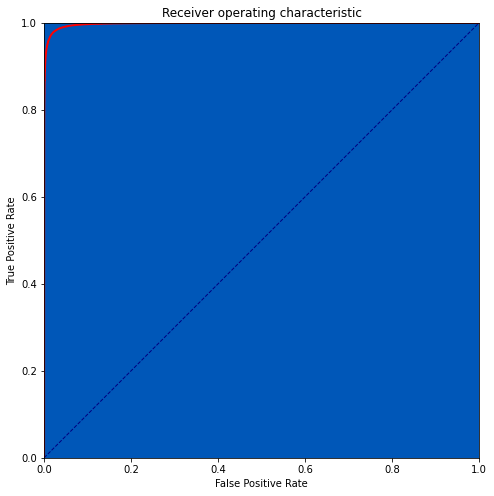

In [8]:
#Three diagrams for model evaluation
# Plot the ROC curve for the last fold [because it looks nice]
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

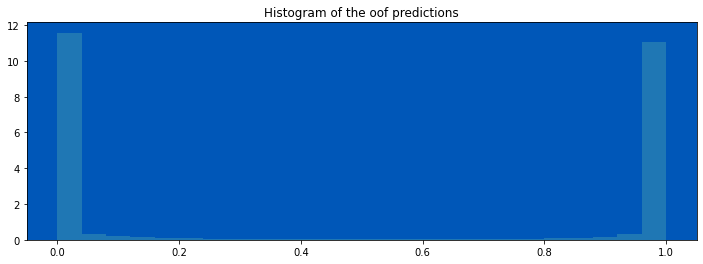

In [9]:
#Second, we plot a histogram of the out-of-fold predictions. Many predictions are near 0.0 or near 1.0;
#this means that in many cases the classifier's predictions have high confidence:

plt.figure(figsize=(12, 4))
plt.hist(y_va_pred, bins=25, density=True)
plt.title('Histogram of the oof predictions')
plt.show()

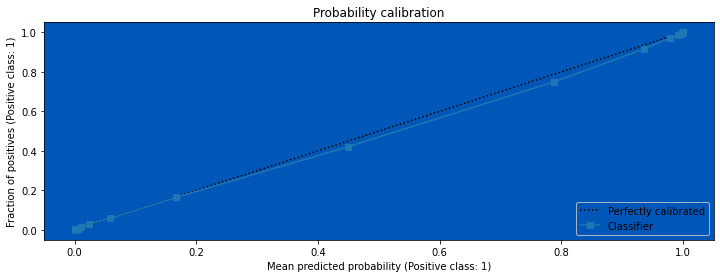

In [10]:
#Finally, plot callibration curve

plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [11]:
#Retrain for submission

# Create submission
print(f"{len(features)} features")

X_tr = train[features]
y_tr = train.target

pred_list = []
for seed in range(10):
    # see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    model, scaler = fit_model(X_tr, y_tr, run=seed)
    pred_list.append(scipy.stats.rankdata(model.predict(scaler.transform(test[features]),
                                                        batch_size=len(test), verbose=0)))
    print(f"{seed:2}", pred_list[-1])
print()
submission = test[['id']].copy()
submission['target'] = np.array(pred_list).mean(axis=0)
submission.to_csv('submission.csv', index=False)
submission

44 features
Training loss: 0.0602
 0 [585611.  595900.5   4650.  ... 305837.  132938.     695. ]
Training loss: 0.0597
 1 [6.752985e+05 5.925550e+05 1.693000e+03 ... 2.992600e+05 1.655930e+05
 3.880000e+02]
Training loss: 0.0600
 2 [581270.5 611984.    2140.  ... 313500.  167536.    1905. ]
Training loss: 0.0598
 3 [676445. 583072.   3771. ... 290726. 168104.   1866.]
Training loss: 0.0608
 4 [563343.  614036.5  52689.  ... 294766.  184029.   22037. ]
Training loss: 0.0600
 5 [466893.  595396.5  19958.  ... 276219.   83842.    2819. ]
Training loss: 0.0600
 6 [464694. 626143.  24669. ... 310614. 155780.   5660.]
Training loss: 0.0599
 7 [5.795680e+05 6.063255e+05 4.831000e+03 ... 2.958430e+05 1.355550e+05
 4.700000e+02]
Training loss: 0.0597
 8 [677864.  615865.5  16174.  ... 306033.  202037.     694. ]
Training loss: 0.0598
 9 [543336.5 569987.    4617.  ... 305741.  164980.    5418. ]



,id,target
0,900000,581432.35
1,900001,601126.55
2,900002,13519.20
3,900003,154261.00
4,900004,475806.00
...,...,...
699995,1599995,357398.60
699996,1599996,560678.70
699997,1599997,299853.90
699998,1599998,156039.40
